使用DCGAN生成AnimateFace96*96数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar
DATA_PATH = '/input/AnimateFace/'
LEARNING_RATE_D = 2e-4
LEARNING_RATE_G = 2e-4
IMAGE_CHANNEL = 3
IMAGE_SIZE = 96
BATCH_SIZE = 64
EPOCH = 100
NOISE_DIM = 100

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # Estimated variance, must be around 1
        m.weight.data.normal_(1.0, 0.02)
        # Estimated mean, must be around 0
        m.bias.data.fill_(0)

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(NOISE_DIM, 64 * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(64 * 8),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 4),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 2),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, IMAGE_CHANNEL, 5, 3, 1, bias=False),
            torch.nn.Tanh()
        )

        weights_init(self)

    def forward(self, x):
        output = self.deconv1(x)
        output = self.deconv2(output)
        output = self.deconv3(output)
        output = self.deconv4(output)
        output = self.deconv5(output)
        return output


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 5, 3, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 2),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 4),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 8),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )
        weights_init(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = output.view(-1)

        return output

# 3.导入数据

In [9]:
NetD = Discriminator()
NetG = Generator()
criterion = torch.nn.BCELoss()

true_labels = torch.autograd.Variable(torch.ones(BATCH_SIZE))
fake_labels = torch.autograd.Variable(torch.zeros(BATCH_SIZE))
fix_noises  = torch.autograd.Variable(torch.randn(100,NOISE_DIM,1,1))
noises      = torch.autograd.Variable(torch.randn(BATCH_SIZE,NOISE_DIM,1,1))

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    criterion = criterion.cuda()
    true_labels,fake_labels = true_labels.cuda(), fake_labels.cuda()
    fix_noises,noises = fix_noises.cuda(),noises.cuda()

optimizerD = torch.optim.Adam(NetD.parameters(),lr=LEARNING_RATE_D,betas=(0.5,0.999), weight_decay=0)
optimizerG = torch.optim.Adam(NetG.parameters(),lr=LEARNING_RATE_G,betas=(0.5,0.999), weight_decay=0)

transform=tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)) ,
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.5]*3,[0.5]*3)
])

dataset = tv.datasets.ImageFolder(root=DATA_PATH, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)


# 4.训练

In [10]:
showbar = bar.ProgressBar(EPOCH, len(dataloader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCH + 1):
    if epoch % 30 == 0:
        optimizerD.param_groups[0]['lr'] /= 10
        optimizerG.param_groups[0]['lr'] /= 10

    for i, data_batch in enumerate(dataloader, 0):
        images, labels = data_batch
        real_img = torch.autograd.Variable(images.cuda() if torch.cuda.is_available() else images)

        NetD.zero_grad()
        ## 尽可能的把真图片判别为正确
        output = NetD(real_img)
        error_d_real = criterion(output,true_labels)
        error_d_real.backward()

        ## 尽可能把假图片判别为错误
        noises.data.copy_(torch.randn(BATCH_SIZE,NOISE_DIM,1,1))
        fake_img = NetG(noises).detach() # 根据噪声生成假图
        output = NetD(fake_img)
        error_d_fake = criterion(output,fake_labels)
        error_d_fake.backward()
        optimizerD.step()
        error_d = error_d_fake + error_d_real

        NetG.zero_grad()
        noises.data.copy_(torch.randn(BATCH_SIZE,NOISE_DIM,1,1))
        fake_img = NetG(noises)
        output = NetD(fake_img)
        error_g = criterion(output,true_labels)
        error_g.backward()
        optimizerG.step()

        showbar.show(epoch, error_d.item(), error_g.item())

Epoch:1 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.633;G Loss:5.114,total=0:02:120
Epoch:2 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.418;G Loss:5.140,total=0:02:12029:13
Epoch:3 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.334;G Loss:5.473,total=0:02:11075:4033
Epoch:4 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.461;G Loss:4.746,total=0:02:11071:2744
Epoch:5 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.529;G Loss:5.412,total=0:02:12017:5927
Epoch:6 / 100 [****************************************************************************************************] 800 / 800 ,D

Epoch:47 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.007;G Loss:6.069,total=0:02:110018:5833
Epoch:48 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.009;G Loss:6.815,total=0:02:110320:33019
Epoch:49 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.004;G Loss:6.485,total=0:02:110221:5803
Epoch:50 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.009;G Loss:7.284,total=0:02:110223:1750
Epoch:51 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.008;G Loss:6.924,total=0:02:110724:2926
Epoch:53 / 100 [*********************************************************************************************

Epoch:93 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.003;G Loss:8.549,total=0:02:120311:5522
Epoch:94 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.003;G Loss:8.313,total=0:02:110510:50943
Epoch:95 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.002;G Loss:8.089,total=0:02:1106409:4245
Epoch:96 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.001;G Loss:8.672,total=0:02:1105:08:3125
Epoch:97 / 100 [****************************************************************************************************] 800 / 800 ,D Loss:0.002;G Loss:8.451,total=0:02:1208:07:2203
Epoch:98 / 100 [******************************************************************************************

# 5.生成

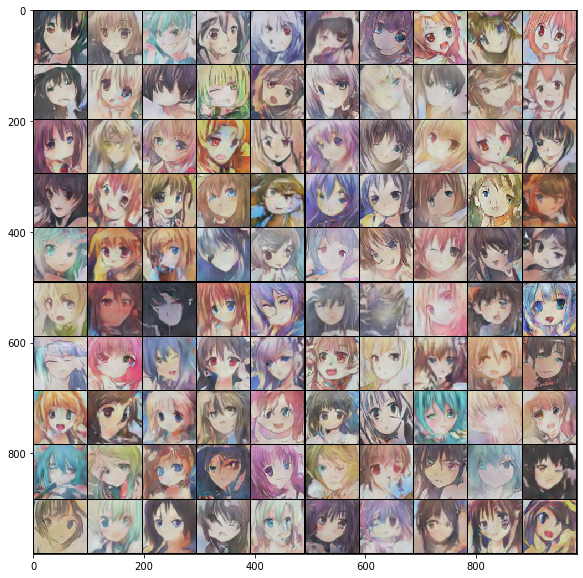

In [13]:
fake_u=NetG(fix_noises)
img = tv.utils.make_grid(fake_u.data, nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))